# Initialization

## Packages

In [ ]:
import datetime, os
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

In [ ]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATA_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Data')
MODEL_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models')
SAVED_MODEL = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models_trained')
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%load_ext tensorboard
log_dir=os.path.join(MODEL_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Pipeline

In [ ]:
def windowed_dataset(series, window_size):
  """Chunks the series to small windows of size:window_size
  and shuffles the dataset"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=None, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  return dataset

In [ ]:
def sequence_preprocessing(data, Id_column,x_column, y_column, window_size):
  """Groups vessels by ID and uses sliding windows to create the dataset
  From shape: (N_samples, features)
  to shape: (N_entries(=Number of windows), window_size, features)"""
  
  #Groups data by ID
  vessels = data.groupby(Id_column)

  for key, group in vessels:
    if(int(group.shape[0]) <= window_size):
      data.drop(data[data[Id_column] == key].index, inplace=True)
  vessels = data.groupby(Id_column)

  vessels_list = []

  #Split each vessel's trajectory into windows
  for _,vessel in vessels:
    vessel_temp = vessel.to_numpy()[:,x_column:y_column].astype('float64')
    windowed_vessel = windowed_dataset(vessel_temp, window_size)
    vessels_list.append(windowed_vessel)

  #Concat
  vessels_list = [[window for window in vessel] for vessel in vessels_list]
  vessels_window = tf.concat(vessels_list, axis=0)

  return vessels_window

# Data

In [ ]:
TRAIN_DIR = 'AIS_2019_01_01.csv'
TEST_DIR = 'AIS_2021_01_01.csv'

window_size = 25
n_in = window_size

id_column = "MMSI"
first_column = 1
last_column = 9

## Train

In [ ]:
train_path = os.path.join(DATA_DIR, TRAIN_DIR)
train_data = pd.read_csv(train_path, delimiter=",")
train_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo', 'TranscieverClass'], axis=1, inplace=True)
train_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
train_data = train_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
train_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
16,368066040,30.33668,-88.29042,6.6,201.1,202.0,30.0,9.0,30.0
20,368045480,47.65037,-122.32944,0.0,176.2,511.0,18.0,6.0,37.0
21,366995280,29.56922,-94.41773,4.6,37.2,23.0,24.0,8.0,31.0
22,367005970,30.37323,-86.10350,0.1,8.2,511.0,21.0,7.0,31.0
23,367006420,30.02076,-93.98032,0.0,-182.3,313.0,21.0,8.0,31.0


In [ ]:
print("types of ships: ", train_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(train_data["MMSI"].unique()))
train_ships = train_data["MMSI"].unique()
print("\nShape :", train_data.shape)

types of ships:  [ 30.  37.  31.  90.  70.  32.  80.  36.  60.  57.  50.  52.   0.  84.
  16.  33.  91.  51.  53.  20.  71.  56.  25.  79.  40.  89.  35.  82.
  99.  54.  34.  77.  74.  47.  38.  76.  49.  97.  10.  81.  59.  67.
  39.  19.  73.  69. 170.]

Number of ships in the dataset are : 8854

Shape : (5487658, 9)


In [ ]:
train_data = train_data.head(3000000)

In [ ]:
train_data = train_data[train_data.VesselType != 0]
train_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                               50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                               80.0: 8, 90.0: 9}, inplace=True)
train_data.drop(train_data[train_data.VesselType > 9].index, inplace=True)
train_data.VesselType.value_counts()

1.0    1428322
6.0     285427
3.0     279797
0.0     274905
7.0     249528
9.0     245975
8.0     116245
2.0      46271
5.0      17015
4.0       9857
Name: VesselType, dtype: int64

In [ ]:
tf_train_data = sequence_preprocessing(train_data, id_column, first_column, last_column, window_size)

In [ ]:
train = tf_train_data
X_train = train[:, :, 0:7]
y_train = train[:, :, 7]
y_train = y_train[:, 1]

print(X_train.shape)
print(y_train.shape)

(114302, 25, 7)
(114302,)


## Test

In [ ]:
test_path=os.path.join(DATA_DIR, TEST_DIR)
test_data = pd.read_csv(test_path, delimiter=",")
test_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo', 'TranscieverClass'], axis=1, inplace=True)
test_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
test_data = test_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
test_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
0,338325166,28.08771,-82.77474,0.0,0.0,511.0,13.0,6.0,37.0
1,368163740,26.10727,-80.12551,0.0,360.0,511.0,18.0,4.0,37.0
2,366811570,30.66150,-88.03264,0.0,196.0,270.0,18.0,7.0,31.0
11,367532810,30.06368,-90.85178,0.0,265.0,297.0,39.0,11.0,31.0
13,367170010,29.89757,-90.07960,0.0,114.0,511.0,21.0,8.0,31.0


In [ ]:
print("types of ships: ", test_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(test_data["MMSI"].unique()))
test_ships = test_data["MMSI"].unique()
print("\nShape :", test_data.shape)

types of ships:  [37. 31. 80. 90. 70. 30. 60. 50.  0. 36. 52. 33. 71. 57. 73. 89. 38. 56.
 20. 51. 99. 79. 53. 35.  9. 25. 94. 32. 72. 97. 40. 34. 47. 49. 10. 82.
 58. 74. 67. 59. 54. 95. 69. 81. 55.]

Number of ships in the dataset are : 8756

Shape : (4651605, 9)


In [ ]:
test_data = test_data.head(1000000)

In [ ]:
test_data = test_data[test_data.VesselType != 0]
test_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                              50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                              80.0: 8, 90.0: 9}, inplace=True)
test_data.drop(test_data[test_data.VesselType > 9].index, inplace=True)
test_data.VesselType.value_counts()

1.0    408728
3.0    172754
0.0     83189
6.0     82257
7.0     79866
9.0     78952
2.0     38410
8.0     28638
5.0      5769
4.0      2191
Name: VesselType, dtype: int64

In [ ]:
tf_test_data = sequence_preprocessing(test_data, id_column, first_column, last_column, window_size)

In [ ]:
test = tf_test_data
X_test = test[:, :, 0:7]
y_test = test[:, :, 7]
y_test = y_test[:, 1]

print(X_test.shape)
print(y_test.shape)

(35816, 25, 7)
(35816,)


## Comparison Ships

The goal is to establish an attack model which can identify the unique ships used for training the target model

In [ ]:
print(train_ships)

[368066040 368045480 366995280 ... 316036599 338502000 316003325]


In [ ]:
matching = list(set(train_ships).intersection(test_ships))
print(len(train_ships))
print(len(test_ships))
print(len(matching))

8854
8756
4238


# LSTM


## Architecture

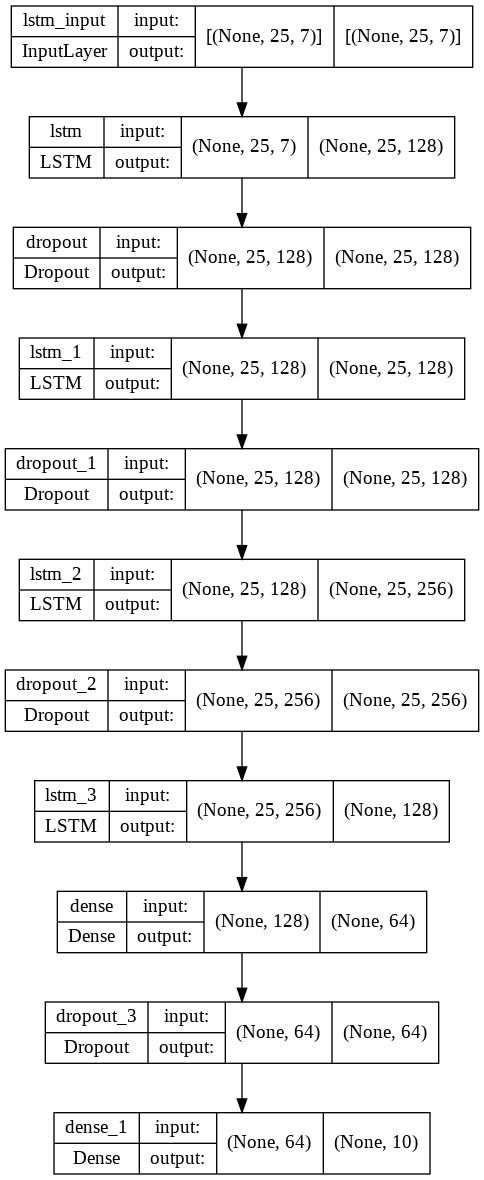

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

plot_model(model, show_shapes=True, to_file='TargetModel.png')

## Training

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'] )

model.fit(X_train, y_train, epochs=50, callbacks = [tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
3572/3572 [==============================] - 154s 40ms/step - loss: 1.1482 - accuracy: 0.6173
Epoch 2/50
3572/3572 [==============================] - 141s 40ms/step - loss: 0.9243 - accuracy: 0.6864
Epoch 3/50
3572/3572 [==============================] - 142s 40ms/step - loss: 0.8147 - accuracy: 0.7235
Epoch 4/50
3572/3572 [==============================] - 142s 40ms/step - loss: 0.7581 - accuracy: 0.7437
Epoch 5/50
3572/3572 [==============================] - 142s 40ms/step - loss: 0.7110 - accuracy: 0.7549
Epoch 6/50
3572/3572 [==============================] - 142s 40ms/step - loss: 0.6668 - accuracy: 0.7711
Epoch 7/50
3572/3572 [==============================] - 143s 40ms/step - loss: 0.6297 - accuracy: 0.7832
Epoch 8/50
3572/3572 [==============================] - 143s 40ms/step - loss: 0.5985 - accuracy: 0.7929
Epoch 9/50
3572/3572 [==============================] - 143s 40ms/step - loss: 0.5689 - accuracy: 0.7980
Epoch 10/50
3572/3572 [==============================] 

In [ ]:
#model = tf.keras.models.load_model(os.path.join(SAVED_MODEL,"FinalTargetModel!.h5"))

In [ ]:
model.save(os.path.join(SAVED_MODEL, "FinalTargetModel!.h5"))

In [ ]:
!tensorboard dev upload --logdir $log_dir. \
  --name "FinalTargetModel" \
  --description "{win=25,shift=None,opt=Adam,loss=SCE}encoder:LSTM(128,relu)" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

.

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Gjl9ed2qWtDAi1iZayJ0yBZ9csCch9&prompt=consent&access_type=offline
Enter the a

## Evaluation

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('\nTrain accuracy:', train_acc)

3572/3572 [==============================] - 56s 15ms/step - loss: 0.1841 - accuracy: 0.9301

Train accuracy: 0.930062472820282


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

1120/1120 [==============================] - 18s 16ms/step - loss: 1.5041 - accuracy: 0.6913

Test accuracy: 0.6913390755653381


In [ ]:
y_test_pred = model.predict(X_test).argmax(axis=1)

In [ ]:
print(y_test_pred[400])
print(y_test[400])

7
tf.Tensor(7.0, shape=(), dtype=float64)


# Confusion Matrix

Text(0.5, 1.0, 'Refined Confusion Matrix')

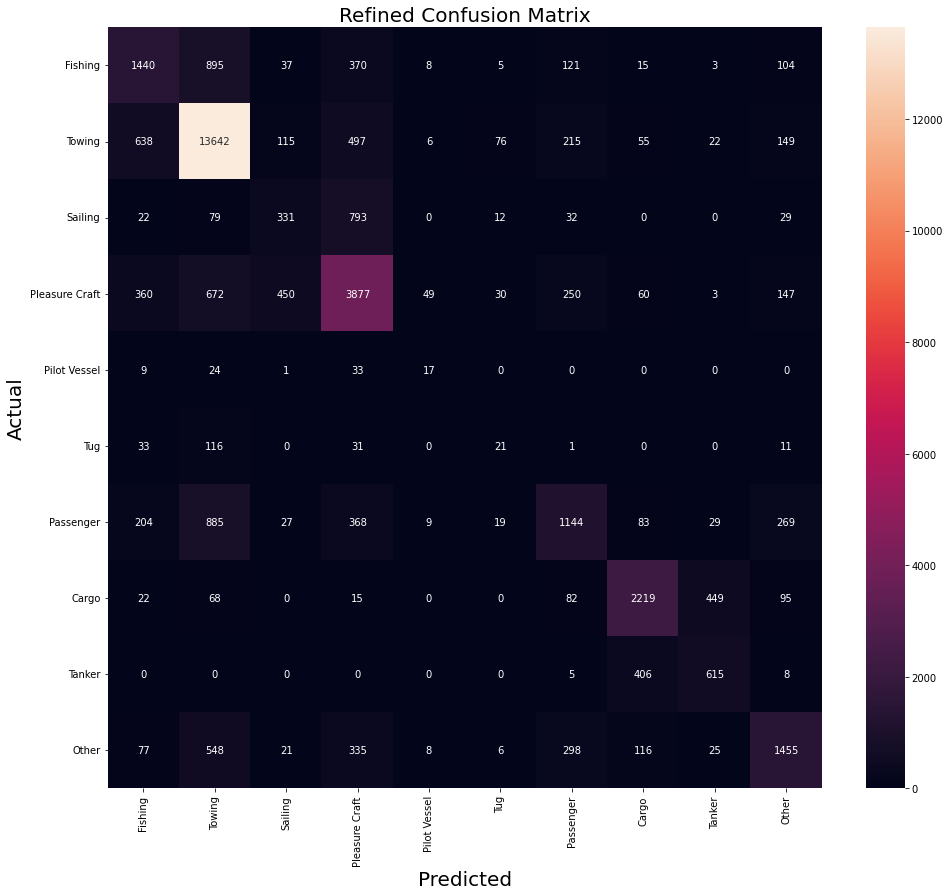

In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
class_names = ['Fishing', 'Towing', 'Sailing', 'Pleasure Craft', 'Pilot Vessel', 'Tug', 'Passenger', 'Cargo', 'Tanker', 'Other']

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

# Black-box Behavior

In [ ]:
IN_prediction = pd.DataFrame(model.predict(X_train))
IN_class = pd.DataFrame(y_train)
IN_label = pd.DataFrame(np.full(y_train.shape, 1))

OUT_prediction = pd.DataFrame(model.predict(X_test))
OUT_class = pd.DataFrame(y_test)
OUT_label = pd.DataFrame(np.full(y_test.shape, 0))

In [ ]:
IN_prediction.insert(10, 'Class', IN_class)
IN_prediction.insert(11, 'Label', IN_label)
IN = IN_prediction

OUT_prediction.insert(10, 'Class', OUT_class)
OUT_prediction.insert(11, 'Label', OUT_label)
OUT = OUT_prediction

In [ ]:
IN.to_csv("IN_TargetModel.csv", index=False)
OUT.to_csv("OUT_TargetModel.csv", index=False)